In [1]:
#conda activate ntl_nx
import osmnx as ox
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import rasterio
from rasterio.mask import mask
import pickle
#you might need conda package manager for gdal to work properly (pip struggles sometimes)
from osgeo import gdal
import os

from shapely.geometry import Point
import numpy as np

my_dir = "/Users/flurin/local_code/netsci_final_project"

# Creating Network with road edge
Map data from https://osmnx.readthedocs.io/en/stable/

Check map here https://www.openstreetmap.org/#map=10/35.7303/-81.6422

In [2]:
# bbox from asheville nc to hickory nc
nc_section = ox.graph.graph_from_bbox(west=-82.7, east=-81.204, north=35.84, south=35.48, network_type='drive', simplify=True)


#ch_highways = ox.graph_from_place("ZH-CH", network_type='drive')#  custom_filter='["highway"~"motorway|trunk|primary|secondary"]') 

/var/folders/n6/gg550s855lz4ddqllzmqm08h0000gn/T/ipykernel_73791/3152865923.py:2: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  nc_section = ox.graph.graph_from_bbox(west=-82.7, east=-81.204, north=35.84, south=35.48, network_type='drive', simplify=True)


In [3]:
with open('nc_section.pickle', 'wb') as f:
    pickle.dump(nc_section, f)

In [4]:
with open('nc_section.pickle', 'rb') as f:
    nc_section = pickle.load(f)

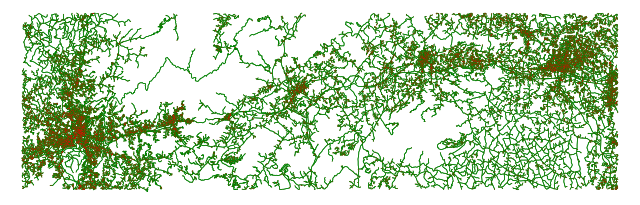

In [5]:
#plot nc_section
fig, ax = ox.plot_graph(nc_section, bgcolor="w", node_color="r", node_size=.1,edge_color="g", edge_linewidth=0.5, show=False, close=False)

/var/folders/n6/gg550s855lz4ddqllzmqm08h0000gn/T/ipykernel_73791/3038519684.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  location_centroid = location_gdf.geometry.centroid.iloc[0]
/var/folders/n6/gg550s855lz4ddqllzmqm08h0000gn/T/ipykernel_73791/3038519684.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  location_centroid = location_gdf.geometry.centroid.iloc[0]


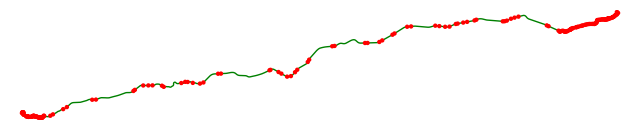

In [6]:
def get_route(start_location, end_location, graph):
    def get_closest_node(location, graph):
        # Get coordinates of centroid of the location
        location_gdf = ox.geocode_to_gdf(location)
        location_centroid = location_gdf.geometry.centroid.iloc[0]
        
        # Find the closest node in the graph
        closest_node = ox.distance.nearest_nodes(graph, X=location_centroid.x, Y=location_centroid.y)
        
        return closest_node

    # Get the closest nodes for the start and end locations
    start_node = get_closest_node(start_location, graph)
    end_node = get_closest_node(end_location, graph)

    # Find the shortest path between the start and end nodes
    route = nx.shortest_path(graph, source=start_node, target=end_node, weight='length')

    return route

# Example usage
route = get_route("Asheville, North Carolina", "Hickory,  North Carolina", nc_section)

# Plot the route
route_nodes = nc_section.subgraph(route)
fig, ax = ox.plot_graph(route_nodes, bgcolor="w", node_color="r", node_size=10,edge_color="g", edge_linewidth=1, show=False, close=False)

In [7]:
route_gdf = ox.graph_to_gdfs(nc_section.subgraph(route), nodes=False, edges=True)
route_object = route_gdf.geometry.union_all()

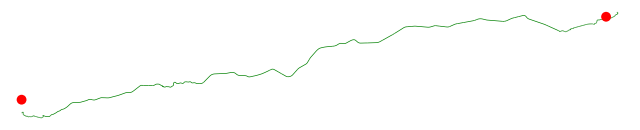

In [8]:
#make network with nodes Hickory and Asheville and add an edge between them with route_object as geometry
G = nx.MultiDiGraph()
G.graph['crs'] = 'epsg:4326'
G.add_node("Hickory",  x=-81.3448, y=35.7345)
G.add_node("Asheville", x=-82.5540, y=35.5951)
G.add_edge("Hickory", "Asheville", geometry=route_object)

#plot the network
fig, ax = ox.plot_graph(G,bgcolor="w", node_color="r",edge_color="g", node_size=50, edge_linewidth=0.5, show=False, close=False)

# Preparing night time light tiles

check tiles https://ladsweb.modaps.eosdis.nasa.gov/search/order (download requires login)

access archive https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/5000/VNP46A2/

hdf5 (.h5) to .tif conversion is cumbersome. Nasa has a code snippet for this https://blackmarble.gsfc.nasa.gov/Tools.html


In [9]:
#asuming the hdf files are in a folder called ntl_hdf in the same directory as the jupyter
os.chdir(my_dir+"/ntl_hdf")
# delete DS_Store file if present
if os.path.exists('.DS_Store'):
    os.remove('.DS_Store')

rasterFiles = os.listdir(os.getcwd())
print(rasterFiles)

for rasterFile in rasterFiles:
    # Get File Name Prefix
    rasterFilePre = rasterFile[:-4]
    print(rasterFilePre)

    fileExtension = ".tif"

    # Open HDF file
    hdflayer = gdal.Open(rasterFile, gdal.GA_ReadOnly)

    # Open raster layer
    #[2][0] is Gap_Filled_DNB_BRDF-Corrected_NTL
    #[0][0] is DNB_BRDF-Corrected_NTL
    rlayer = gdal.Open(hdflayer.GetSubDatasets()[2][0], gdal.GA_ReadOnly)

    outputNameFinal = rasterFilePre + fileExtension
    print(outputNameFinal)

    outputFolder = my_dir + "/ntl_tiff/"
    outputRaster = outputFolder + outputNameFinal

    gdal.Warp(outputRaster, rlayer)

['VNP46A2.A2024266.h09v05.001.2024276122633.h5', 'VNP46A2.A2024277.h09v05.001.2024285095335.h5', 'VNP46A2.A2024278.h09v05.001.2024286093751.h5', 'VNP46A2.A2024267.h09v05.001.2024276141915.h5', 'VNP46A2.A2024269.h09v05.001.2024277103018.h5', 'VNP46A2.A2024275.h09v05.001.2024283104752.h5', 'VNP46A2.A2024273.h09v05.001.2024282170954.h5', 'VNP46A2.A2024276.h09v05.001.2024284202837.h5', 'VNP46A2.A2024272.h09v05.001.2024282161647.h5', 'VNP46A2.A2024268.h09v05.001.2024276161356.h5', 'VNP46A2.A2024279.h09v05.001.2024287093109.h5', 'VNP46A2.A2024274.h09v05.001.2024282174747.h5']
VNP46A2.A2024266.h09v05.001.202427612263
VNP46A2.A2024266.h09v05.001.202427612263.tif


/Users/flurin/miniconda3/envs/ntl_nx/lib/python3.10/site-packages/osgeo/gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


VNP46A2.A2024277.h09v05.001.202428509533
VNP46A2.A2024277.h09v05.001.202428509533.tif
VNP46A2.A2024278.h09v05.001.202428609375
VNP46A2.A2024278.h09v05.001.202428609375.tif
VNP46A2.A2024267.h09v05.001.202427614191
VNP46A2.A2024267.h09v05.001.202427614191.tif
VNP46A2.A2024269.h09v05.001.202427710301
VNP46A2.A2024269.h09v05.001.202427710301.tif
VNP46A2.A2024275.h09v05.001.202428310475
VNP46A2.A2024275.h09v05.001.202428310475.tif
VNP46A2.A2024273.h09v05.001.202428217095
VNP46A2.A2024273.h09v05.001.202428217095.tif
VNP46A2.A2024276.h09v05.001.202428420283
VNP46A2.A2024276.h09v05.001.202428420283.tif
VNP46A2.A2024272.h09v05.001.202428216164
VNP46A2.A2024272.h09v05.001.202428216164.tif
VNP46A2.A2024268.h09v05.001.202427616135
VNP46A2.A2024268.h09v05.001.202427616135.tif
VNP46A2.A2024279.h09v05.001.202428709310
VNP46A2.A2024279.h09v05.001.202428709310.tif
VNP46A2.A2024274.h09v05.001.202428217474
VNP46A2.A2024274.h09v05.001.202428217474.tif


# Combine NTL tiles with Graph

In [10]:
# read the tif file in ntl_tiles_tiff
os.chdir(str(my_dir) + "/ntl_tiff")
example_tile = os.listdir(os.getcwd())[0]
print(example_tile)
tile = rasterio.open(example_tile)

print(tile.bounds)
#print entries in first 10 rows and columns
print(tile.read(1)[0:5, 0:10])
print("unique values in the tile: ", np.unique(tile.read(1)))
# note that 65535 is filler value
max_val=sorted(np.unique(tile.read(1)))[-2]

VNP46A2.A2024275.h09v05.001.202428310475.tif
BoundingBox(left=-90.0, bottom=30.0, right=-80.0, top=40.0)
[[1 1 1 2 1 1 7 7 4 4]
 [7 1 1 1 1 1 0 4 4 4]
 [7 2 1 1 1 2 1 4 6 1]
 [7 2 1 1 1 2 7 1 1 1]
 [2 2 1 1 1 3 7 1 1 1]]
unique values in the tile:  [    0     1     2 ...  5956  6739 65535]


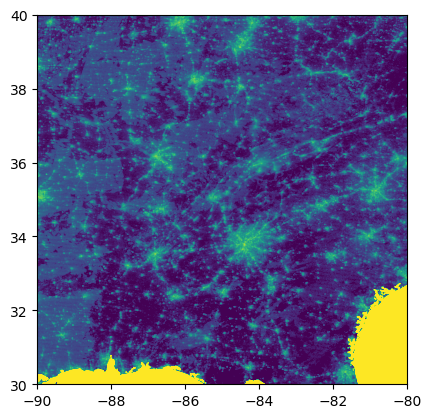

In [11]:
#plot tile with correct coordinates
fig, ax = plt.subplots()
plt.imshow(tile.read(1), cmap='viridis', norm="log", vmax=max_val,  extent=[tile.bounds.left, tile.bounds.right, tile.bounds.bottom, tile.bounds.top]) #vmax=sorted(np.unique(tile.read(1)))[-2],
plt.show()

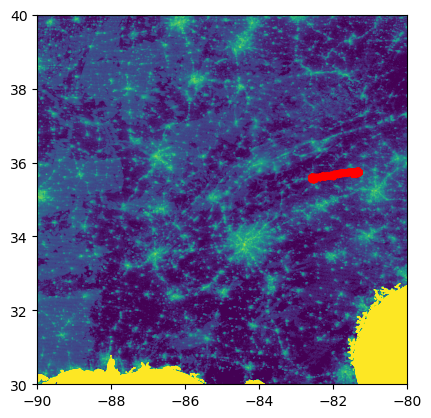

In [12]:
# plot linestring on top of the tile
fig, ax = plt.subplots()
plt.imshow(tile.read(1), cmap='viridis', norm="log", vmax=max_val,  extent=[tile.bounds.left, tile.bounds.right, tile.bounds.bottom, tile.bounds.top]) #vmax=sorted(np.unique(tile.read(1)))[-2],
# plot G["Hickory"]["Asheville"][0]["geometry"].geoms which are linestrings
for line in G["Hickory"]["Asheville"][0]["geometry"].geoms:
    x, y = line.xy
    plt.plot(x, y, color="red", linewidth=5)


plt.show()

In [13]:
print(type(G["Hickory"]["Asheville"][0]["geometry"].geoms[0]))
from shapely.geometry import shape
print(shape(G["Hickory"]["Asheville"][0]["geometry"].geoms[0]))

<class 'shapely.geometry.linestring.LineString'>
LINESTRING (-82.5145698 35.5647177, -82.5139532 35.5646146)


[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


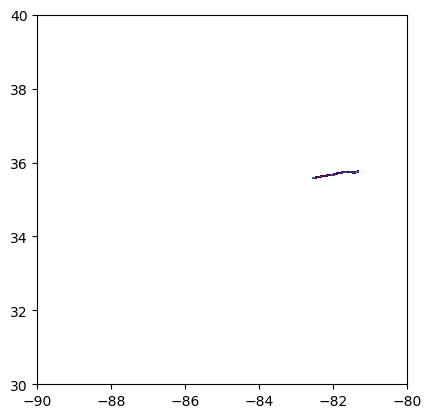

In [14]:
# mask the tif file with the route_object. all pixels touching the route_object will be kept
crop_img, crop_transform = mask(tile, shapes = G["Hickory"]["Asheville"][0]["geometry"].geoms, crop=False, all_touched=True)
crop_img[crop_img == 65535] = 0 # set filler value to 0
print(crop_img)

fig, ax = plt.subplots()
plt.imshow(crop_img[0], cmap='viridis', norm="log", vmax=max_val,  extent=[tile.bounds.left, tile.bounds.right, tile.bounds.bottom, tile.bounds.top])
plt.show()

In [15]:
#append sum of pixel values in crop_img[0] as feature to edge in route_object

# get the pixel values of the cropped image
pixel_sum = crop_img[0].flatten().sum()

#append to G as edge attribute for the edge between Hickory and Asheville
G["Hickory"]["Asheville"][0]["ntl_sum"] = pixel_sum
#print edge attributes
print(G.edges(data=True))

[('Hickory', 'Asheville', {'geometry': <MULTILINESTRING ((-82.515 35.565, -82.514 35.565), (-82.515 35.565, -82.515...>, 'ntl_sum': np.uint64(24784)})]
